In [1]:
import pandas as pd
import numpy as np

In [2]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [3]:
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

In [4]:
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn), tp, fp, fn

In [5]:
def calculate_image_precision(image_id, gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None
    csv_record = {'image': image_id, 'total_predictions': len(preds)}
    for threshold in thresholds:
        precision_at_threshold, tp, fp, fn = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold
        csv_record['tp@{}(IoU)'.format(threshold)] = tp
        csv_record['fp@{}(IoU)'.format(threshold)] = fp
        csv_record['fn@{}(IoU)'.format(threshold)] = fn
        csv_record['AP@{}(IoU)'.format(threshold)] = precision_at_threshold
    csv_record['mAP'.format(threshold)] = image_precision
    return image_precision, csv_record

In [6]:
def evaluate_one_frame(frame_index, df_gt, df_pred, iou_thresholds):
    
    gt_boxes = df_gt[df_gt['frame'] == frame_index][['y', 'x', 'w', 'h']].values
    gt_boxes = gt_boxes.astype(np.int)
    
    
    pred_box = df_pred[df_pred['frame'] == frame_index][['y', 'x', 'w', 'h']].values
    pred_box = pred_box.astype(np.int)
    pred_scores = df_pred[df_pred['frame'] == frame_index]['score'].values
    pred_scores = pred_scores.astype(np.float)
    
    preds_sorted_idx = np.argsort(pred_scores)[::-1]
    preds_sorted = pred_box[preds_sorted_idx]
    
    image_precision, csv_record = calculate_image_precision(frame_index, gt_boxes, preds_sorted,
                                            thresholds=iou_thresholds,
                                            form='coco')

#     print("The average precision of the sample image: {0:.4f}".format(image_precision))
    return csv_record
#     print(csv_record)
    
    
    

In [7]:
def evaluate_save_all_frames(df_gt, df_pred):
    frame_count = df_gt['frame'].unique().shape[0]
    iou_thresholds = []
    for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
        iou_thresholds.append(x)
    
    csv_records = []
    for frame_index in range(frame_count):
        record = evaluate_one_frame(frame_index, df_gt, df_pred, iou_thresholds)
        csv_records.append(record)
    
    df_result = pd.DataFrame(csv_records)
    df_result = df_result.round(3)
    df_result.to_csv(save_path, index=None)



In [26]:
ant_folder = 3
dataset_type = 'simple_dataset'
file_name = 'original:_300-resize:_75-{}_ants'.format(ant_folder)
save_path = '/Users/chamathabeysinghe/Projects/monash/VAE_v2/evaluations/{}/{}.csv'.format(dataset_type, file_name)
gt_csv = "/Users/chamathabeysinghe/Projects/monash/VAE_v2/data/synthetic/{}/{}.csv".format(dataset_type, file_name)
prd_csv = "/Users/chamathabeysinghe/Projects/monash/VAE_v2/predictions/{}/{}.csv".format(dataset_type, file_name)
df_gt = pd.read_csv(gt_csv)
df_pred = pd.read_csv(prd_csv)

In [27]:
evaluate_save_all_frames(df_gt, df_pred)

## Visual verification

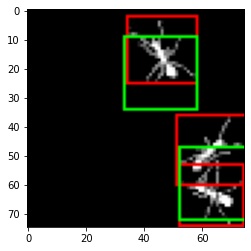

In [28]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
frame = 4
image_path = "/Users/chamathabeysinghe/Projects/monash/VAE_v2/data/synthetic/{}/{}/{:05d}.png".format(dataset_type, file_name, frame)
gt_boxes = df_gt[df_gt['frame'] == frame][['y', 'x', 'w', 'h']].values
gt_boxes = gt_boxes.astype(np.int)
pred_box = df_pred[df_pred['frame'] == frame][['y', 'x', 'w', 'h']].values
pred_box = pred_box.astype(np.int)

def draw_bboxes_img(img, bboxes, color):
    draw = ImageDraw.Draw(img)
    for i, bbox in enumerate(bboxes):
        x, y, w, h = bbox
        draw.rectangle([x, y, x + w, y + h], outline=color)

img = Image.open(image_path)
img = img.convert('RGB')
draw_bboxes_img(img, gt_boxes, (255, 0, 0))
draw_bboxes_img(img, pred_box, (0, 255, 0))
plt.imshow(img)      